In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, pauli_error

In [38]:
gate_error = 1e-2
p_gates_error = 0.5*(1-sum([(1-2*gate_error)**i for i in range(4)])/4)
measurement_error = 5e-2
classical_error = 1e-5
pQBER = (1-(1-2*p_gates_error)*(1-2*measurement_error)*(1-2*classical_error))/2
false_alarm = 1e-2
error_margin = 5e-2
s = int(np.ma.log(1/false_alarm)//(2*error_margin**2))
ds = np.ma.sqrt(np.ma.log(1/false_alarm)/(2*s))
error_threshold = pQBER + ds
print(s,error_threshold)

921 0.11333055749305179


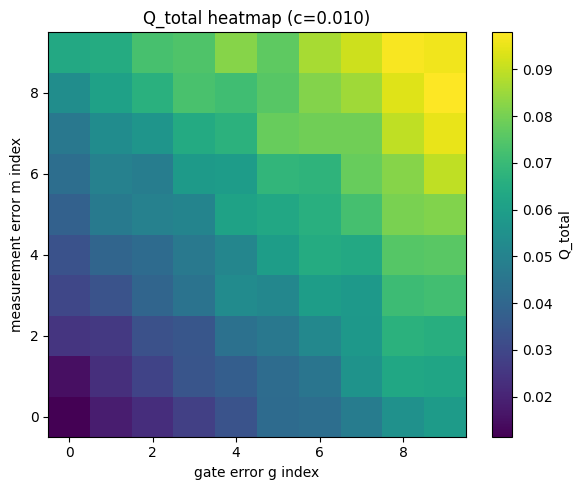

In [9]:
gate_errors     = np.linspace(0.001, 0.05, 10)   # 10 values for g
meas_errors     = np.linspace(0.001, 0.05, 10)   # 10 values for m
class_errors    = np.linspace(0.0,   0.02,  5)   # 5 values for classical error c
shots_per_point = 10_000                         # matched-basis trials per (g, m, c)

results = []

# -------------------------------------------------------------------
# Sweep over g, m, c
# -------------------------------------------------------------------
for g in gate_errors:
    pe_gate = pauli_error([("X", g), ("I", 1 - g)])
    
    for m in meas_errors:
        pe_meas = pauli_error([("X", m), ("I", 1 - m)])
        
        for c in class_errors:
            # build fresh noise model for quantum noise
            noise_model = NoiseModel()
            noise_model.add_all_qubit_quantum_error(pe_gate, ["x", "h"])
            noise_model.add_all_qubit_quantum_error(pe_meas, "measure")
            sim = AerSimulator(noise_model=noise_model)
            
            errors = 0
            total  = 0

            # run matched-basis BB84 trials
            while total < shots_per_point:
                a = np.random.randint(2)  # Alice’s bit
                b = np.random.randint(2)  # Alice’s basis
                c_bob = np.random.randint(2)  # Bob’s basis
                if b != c_bob:
                    continue

                qc = QuantumCircuit(1, 1)
                if a:        qc.x(0)
                if b == 1:   qc.h(0)
                if c_bob == 1: qc.h(0)
                qc.measure(0, 0)

                counts = sim.run(qc, shots=1).result().get_counts()
                bit = int(next(iter(counts)))

                # classical bit-flip with probability c
                if np.random.rand() < c:
                    bit ^= 1

                if bit != a:
                    errors += 1
                total  += 1

            Q_total = errors / total
            results.append((g, m, c, Q_total))

# -------------------------------------------------------------------
# Save results
# -------------------------------------------------------------------
df = pd.DataFrame(results, columns=['gate_error','meas_error','class_error','Q_total'])
df.to_csv('bb84_Qtotal_results.csv', index=False)

# -------------------------------------------------------------------
# Plotting example: heatmap for c=0 slice
# -------------------------------------------------------------------
c_fixed = class_errors[2]  # pick middle classical error
df_c = df[df['class_error'] == c_fixed].pivot(
    index='meas_error', columns='gate_error', values='Q_total'
)

plt.figure(figsize=(6,5))
plt.imshow(df_c, origin='lower', interpolation='nearest', aspect='auto')
plt.colorbar(label='Q_total')
plt.xlabel('gate error g index')
plt.ylabel('measurement error m index')
plt.title(f'Q_total heatmap (c={c_fixed:.3f})')
plt.tight_layout()
plt.show()

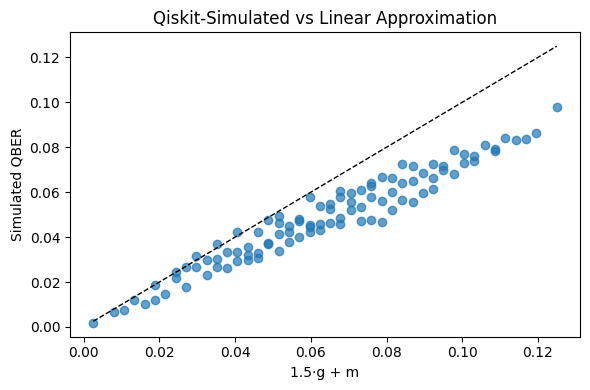

In [2]:
# -------------------------------------------------------------------
# Parameters
# -------------------------------------------------------------------
gate_errors = np.linspace(0.001, 0.05, 10)   # 10 values from 0.001 to 0.05
meas_errors = np.linspace(0.001, 0.05, 10)   # 10 values from 0.001 to 0.05
shots_per_point = 10_000                     # number of BB84 runs per (g, m)

results = []

# -------------------------------------------------------------------
# Loop over error pairs
# -------------------------------------------------------------------
for g in gate_errors:
    # pauli_error takes a list of (pauli, prob)
    pe_gate = pauli_error([("X", g), ("I", 1 - g)])
    
    # Build noise model: apply gate error to X and H, measurement error to measure    
    for m in meas_errors:
        noise_model = NoiseModel()
        pe_meas = pauli_error([("X", m), ("I", 1 - m)])
        noise_model.add_all_qubit_quantum_error(pe_gate, ["x", "h"])
        noise_model.add_all_qubit_quantum_error(pe_meas, "measure")

        sim = AerSimulator(noise_model=noise_model)

        errors = 0
        total  = 0
        
        # Run many BB84 “shots” until bases match
        for _ in range(shots_per_point):
            # build one-qubit circuit with random bases
            a = np.random.randint(2)  # Alice’s bit
            b = np.random.randint(2)  # Alice’s basis: 0=Z,1=X
            c = np.random.randint(2)  # Bob’s basis:   0=Z,1=X
            
            if b != c:
                # skip this shot if bases differ; we only count matched-basis rounds
                continue
            
            qc = QuantumCircuit(1, 1)
            if a == 1:
                qc.x(0)
            if b == 1:
                qc.h(0)
            # Bob’s H if c == 1
            if c == 1:
                qc.h(0)
            qc.measure(0, 0)
            
            # simulate
            job = sim.run(qc, shots=1)
            result = job.result().get_counts()
            # extract measured bit
            measured = int(list(result.keys())[0])
            
            errors += (measured != a)
            total  += 1
        
        qber = errors / total
        lin_approx = 1.5 * g + m
        results.append((g, m, qber, lin_approx))

# -------------------------------------------------------------------
# Save and plot
# -------------------------------------------------------------------
df = pd.DataFrame(results, columns=['gate_error', 'meas_error', 'sim_QBER', 'lin_approx'])
df.to_csv('qber_qiskit_results.csv', index=False)

plt.figure(figsize=(6,4))
plt.scatter(df['lin_approx'], df['sim_QBER'], alpha=0.7)
minv, maxv = df['lin_approx'].min(), df['lin_approx'].max()
plt.plot([minv, maxv], [minv, maxv], 'k--', linewidth=1)
plt.xlabel('1.5·g + m')
plt.ylabel('Simulated QBER')
plt.title('Qiskit-Simulated vs Linear Approximation')
plt.tight_layout()
plt.show()

In [9]:
# Experiment parameters
n = 2000              # number of sifted bits per run
shots = 1024          # shots per measurement
runs_per_setting = 10 # repeat each setting this many times

# Define error ranges (probabilities between 0 and 1)
gate_error_values = np.linspace(0.0, 0.2, 10)         # from 0% to 20% gate error
measurement_error_values = np.linspace(0.0, 0.2, 10)  # from 0% to 20% measurement error
# classical_error_values = np.linspace(0,0.5,6)    # from 0% to 50% classical channel error
classical_error_values = [1e-18]
# Prepare to collect results
results = []

total_settings = len(gate_error_values) * len(measurement_error_values) * len(classical_error_values)
setting_index = 0

for gate_err in gate_error_values:
    if gate_err <= 0.01:
        pass
    for meas_err in measurement_error_values:
        if meas_err <= 0.01:
            pass
        for class_err in classical_error_values:
            setting_index += 1
            print(f"[Progress] Setting {setting_index}/{total_settings} -> gate={gate_err:.3f}, meas={meas_err:.3f}, class={class_err:.3f} "
                  f"({(setting_index/total_settings)*100:.1f}% complete)")
            error_rates = []

            for run in range(1, runs_per_setting + 1):
                print(f"  Running trial {run}/{runs_per_setting}...")

                # Build noise model for this setting
                error_meas = pauli_error([('X', meas_err), ('I', 1 - meas_err)])
                error_gate = pauli_error([('X', gate_err), ('I', 1 - gate_err)])
                noise_model = NoiseModel()
                noise_model.add_all_qubit_quantum_error(error_meas, 'measure')
                noise_model.add_all_qubit_quantum_error(error_gate, ['x', 'h'])

                simulator = AerSimulator(noise_model=noise_model)

                alice_bits = []
                bob_bits   = []

                # Generate and measure n sifted bits
                while len(alice_bits) < n:
                    qc = QuantumCircuit(1, 1)
                    a = np.random.randint(0, 2)
                    b = np.random.randint(0, 2)
                    c = np.random.randint(0, 2)

                    if a:
                        qc.x(0)
                    if b:
                        qc.h(0)
                    if c:
                        qc.h(0)

                    # Sift; only keep when bases match
                    if b == c:
                        alice_bits.append(a)
                        qc.measure(0, 0)
                        counts = simulator.run(qc, shots=shots).result().get_counts()
                        zeros = counts.get('0', 0)
                        ones  = counts.get('1', 0)
                        outcome = 0 if zeros > ones else 1

                        # Transmit measured bit over classical channel with bit-flip error
                        transmitted_bit = outcome
                        if np.random.rand() < class_err:
                            transmitted_bit = 1 - transmitted_bit

                        bob_bits.append(transmitted_bit)

                # Compute error rate for this run
                mismatches = sum(a != b for a, b in zip(alice_bits, bob_bits))
                error_rate = mismatches / n
                error_rates.append(error_rate)

            # Aggregate results for this setting
            min_err = np.min(error_rates)
            max_err = np.max(error_rates)
            avg_err = np.mean(error_rates)
            results.append({
                'gate_error': gate_err,
                'measurement_error': meas_err,
                'classical_error': class_err,
                'min_experimental_error': min_err,
                'max_experimental_error': max_err,
                'avg_experimental_error': avg_err
            })

# Save to CSV
df = pd.DataFrame(results)
df.to_csv('quantum_error_results.csv', index=False)
print('All settings complete. Results written to quantum_error_results.csv')


[Progress] Setting 1/100 -> gate=0.000, meas=0.000, class=0.000 (1.0% complete)
  Running trial 1/10...
  Running trial 2/10...
  Running trial 3/10...
  Running trial 4/10...
  Running trial 5/10...
  Running trial 6/10...
  Running trial 7/10...
  Running trial 8/10...
  Running trial 9/10...
  Running trial 10/10...
[Progress] Setting 2/100 -> gate=0.000, meas=0.022, class=0.000 (2.0% complete)
  Running trial 1/10...
  Running trial 2/10...
  Running trial 3/10...
  Running trial 4/10...
  Running trial 5/10...
  Running trial 6/10...
  Running trial 7/10...
  Running trial 8/10...
  Running trial 9/10...
  Running trial 10/10...
[Progress] Setting 3/100 -> gate=0.000, meas=0.044, class=0.000 (3.0% complete)
  Running trial 1/10...
  Running trial 2/10...
  Running trial 3/10...
  Running trial 4/10...
  Running trial 5/10...
  Running trial 6/10...
  Running trial 7/10...
  Running trial 8/10...
  Running trial 9/10...
  Running trial 10/10...
[Progress] Setting 4/100 -> gate=0.00